### install and import

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q wandb
!gdown 1Cqnir2dySdGKpV2h7AZckXv87L-6Zer- -O anecdots.csv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 13.7 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=1Cqnir2dySdGKpV2h7AZckXv87L-6Zer-
To: /content/anecdots.csv
100% 91.1M/91.1M [00:00<00:00, 108MB/s]


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import re
import shutil
import json

from sklearn.model_selection import train_test_split

import torch

from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from transformers import AutoConfig

import wandb

### pretrained models

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2", padding_side='left')

model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2", 
                                             pad_token_id = tokenizer.eos_token_id)

Downloading:   0%|          | 0.00/609 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/3.14G [00:00<?, ?B/s]

In [ ]:
encoder_input_str = "встретил я как-то медведя в огороде"
input_ids = tokenizer(encoder_input_str, return_tensors="pt").input_ids

torch.manual_seed(0)
outputs = model.generate(input_ids,
                         do_sample=True, 
                         max_length=100, 
                         num_beams=1,
                         no_repeat_ngram_size=2,
                         early_stopping=True,
                         )
print(tokenizer.batch_decode(outputs, skip_special_tokens=True)[0])

встретил я как-то медведя в огороде - на огородике. Сидит себе, отдыхает. Увидел я медведя, а он сидит и медитирует. Спрашиваю, типа, чего ты медитировать такой важный? А он говорит по слогам "т-с-ца".
Вот, говорю, ты медведь, так медведем и оставайся. Как только медведь понял, что я его понимаю без переводчика, он тут же сделал стойку на задние лапы и встал


### fine-tuning 

#### dataset EDA

In [ ]:
!gdown 1Cqnir2dySdGKpV2h7AZckXv87L-6Zer- -O anecdots.csv

Downloading...
From: https://drive.google.com/uc?id=1Cqnir2dySdGKpV2h7AZckXv87L-6Zer-
To: /content/anecdots.csv
100% 91.1M/91.1M [00:00<00:00, 205MB/s]


In [ ]:
data = pd.read_csv('anecdots.csv')
data['jokes'][0]

'Пью медицинский спирт, закусываю докторской колбасой, а здоровье, почему-то, всё хуже и хуже.'

Среднее: 193.5811543813514
Медиана: 113.0
95 процентиль: 625.0


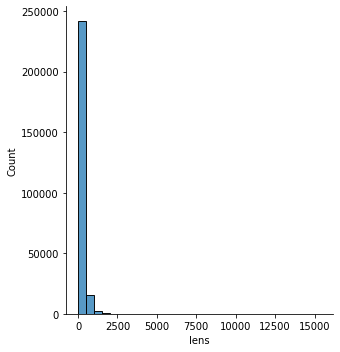

In [ ]:
lenghts = []
for text in data['jokes']:
    lenghts.append(len(text))

sns.displot(pd.Series(lenghts, name='lens'), bins=30)

print('Среднее:', np.mean(lenghts))
print('Медиана:', np.median(lenghts))
print('95 процентиль:', np.percentile(lenghts, 95))

95% всех данных имеют длины меньше 625

удаляем выбросы

Длина: 247791
Среднее: 151.02441977311526
Медиана: 108.0


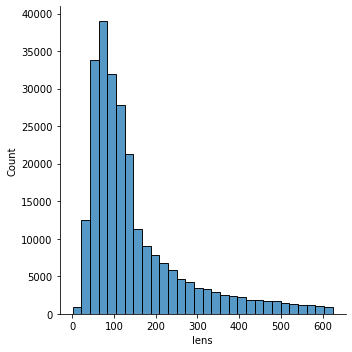

In [ ]:
filtered_dataset = []
filtered_lens = []
for text in data['jokes']:
    if len(text)< 625:
        filtered_lens.append(len(text))
        filtered_dataset.append(text)

print('Длина:', len(filtered_lens))

sns.displot(pd.Series(filtered_lens, name='lens'), bins=30)

print('Среднее:', np.mean(filtered_lens))
print('Медиана:', np.median(filtered_lens))

Возьмем часть датасета, где длина меньше 100, примерно такой гиперпараметр и будем использовать при генерации

Длина: 192242
Среднее: 96.26633097866231
Медиана: 90.0


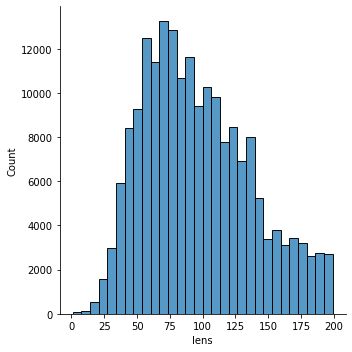

In [ ]:
filtered_dataset = []
filtered_lens = []
for text in data['jokes']:
    if len(text) < 100:
        filtered_lens.append(len(text))
        filtered_dataset.append(text)

print('Длина:', len(filtered_lens))

sns.displot(pd.Series(filtered_lens, name='lens'), bins=30)

print('Среднее:', np.mean(filtered_lens))
print('Медиана:', np.median(filtered_lens))

#### dataset preparing

In [ ]:
def build_text_files(dataset, dest_path):
    
    data = ''
    for text in dataset:
        filtered_text = text.strip()
        filtered_text = re.sub(r"\s", " ", filtered_text)
        data += filtered_text + "  "

    with open(dest_path, 'w') as f:
        f.write(data)

train, test = train_test_split(filtered_dataset, test_size=0.2) 

build_text_files(train,'train_dataset.txt')
build_text_files(test,'test_dataset.txt')

print("Train dataset length: "+str(len(train)))
print("Test dataset length: "+ str(len(test)))

Train dataset length: 153793
Test dataset length: 38449


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2", padding_side='left')

train_path = 'train_dataset.txt'
test_path = 'test_dataset.txt'

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def load_dataset(train_path,test_path,tokenizer):
    train_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=train_path,
          block_size=128)
     
    test_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=test_path,
          block_size=128)   
    
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False,
    )
    return train_dataset,test_dataset,data_collator

train_dataset,test_dataset,data_collator = load_dataset(train_path,test_path,tokenizer)

/usr/local/lib/python3.8/dist-packages/transformers/data/datasets/language_modeling.py:54: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


#### training

In [ ]:
model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2", 

                                             pad_token_id = tokenizer.eos_token_id)
os.environ['WANDB_LOG_MODEL'] = 'end'

training_args = TrainingArguments(
    output_dir="gpt3-shutki", #The output directory
    num_train_epochs=10, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    eval_steps=200, # Number of update steps between two evaluations.
    save_steps=400, # after # steps model is saved 
    warmup_steps=200,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    overwrite_output_dir = True,
    report_to="wandb"
    )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [ ]:
trainer.train()
wandb.finish()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 32757
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 10240
  Number of trainable parameters = 125231616
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
500,3.763800
1000,3.587900
1500,3.407300
2000,3.377200
2500,3.237300
3000,3.219200
3500,3.103400
4000,3.102300
4500,3.004300
5000,2.994000


Saving model checkpoint to gpt3-shutki/checkpoint-400
Configuration saved in gpt3-shutki/checkpoint-400/config.json
Configuration saved in gpt3-shutki/checkpoint-400/generation_config.json
Model weights saved in gpt3-shutki/checkpoint-400/pytorch_model.bin
Saving model checkpoint to gpt3-shutki/checkpoint-800
Configuration saved in gpt3-shutki/checkpoint-800/config.json
Configuration saved in gpt3-shutki/checkpoint-800/generation_config.json
Model weights saved in gpt3-shutki/checkpoint-800/pytorch_model.bin
Saving model checkpoint to gpt3-shutki/checkpoint-1200
Configuration saved in gpt3-shutki/checkpoint-1200/config.json
Configuration saved in gpt3-shutki/checkpoint-1200/generation_config.json
Model weights saved in gpt3-shutki/checkpoint-1200/pytorch_model.bin
Saving model checkpoint to gpt3-shutki/checkpoint-1600
Configuration saved in gpt3-shutki/checkpoint-1600/config.json
Configuration saved in gpt3-shutki/checkpoint-1600/generation_config.json
Model weights saved in gpt3-shutk

Step,Training Loss
500,3.763800
1000,3.587900
1500,3.407300
2000,3.377200
2500,3.237300
3000,3.219200
3500,3.103400
4000,3.102300
4500,3.004300
5000,2.994000


Saving model checkpoint to gpt3-shutki/checkpoint-7600
Configuration saved in gpt3-shutki/checkpoint-7600/config.json
Configuration saved in gpt3-shutki/checkpoint-7600/generation_config.json
Model weights saved in gpt3-shutki/checkpoint-7600/pytorch_model.bin
Saving model checkpoint to gpt3-shutki/checkpoint-8000
Configuration saved in gpt3-shutki/checkpoint-8000/config.json
Configuration saved in gpt3-shutki/checkpoint-8000/generation_config.json
Model weights saved in gpt3-shutki/checkpoint-8000/pytorch_model.bin
Saving model checkpoint to gpt3-shutki/checkpoint-8400
Configuration saved in gpt3-shutki/checkpoint-8400/config.json
Configuration saved in gpt3-shutki/checkpoint-8400/generation_config.json
Model weights saved in gpt3-shutki/checkpoint-8400/pytorch_model.bin
Saving model checkpoint to gpt3-shutki/checkpoint-8800
Configuration saved in gpt3-shutki/checkpoint-8800/config.json
Configuration saved in gpt3-shutki/checkpoint-8800/generation_config.json
Model weights saved in gp

train/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train/global_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,█▇▆▅▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,10.0
train/global_step,10240


In [ ]:
wandb.finish()

### inference pipeline

#### load saved chekpoint

In [ ]:
!pip install -q --upgrade gdown
!gdown 1O96ei4MObTfTml52z7yzAoGLK-oHnWdv -O checkpoint-800.zip

In [ ]:
shutil.unpack_archive('checkpoint-800.zip')
shutil.move('/content/content/gpt3-shutki/checkpoint-800', '/content')

'content/checkpoint-800'

In [ ]:
model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2", 
                                             pad_token_id = tokenizer.eos_token_id)

training_args = TrainingArguments(
    output_dir="gpt3-shutki", #The output directory
    num_train_epochs=1, # number of training epochs
    per_device_train_batch_size=4, # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    eval_steps=1, # Number of update steps between two evaluations.
    save_steps=1, # after # steps model is saved 
    warmup_steps=0,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

Downloading:   0%|          | 0.00/551M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
trainer.train(resume_from_checkpoint='/content/checkpoint-800')

Loading model from /content/checkpoint-800.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6728
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 1682
  Number of trainable parameters = 125231616
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 800
  Will skip the first 0 epochs then the first 800 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training 

  0%|          | 0/800 [00:00<?, ?it/s]

Step,Training Loss


Saving model checkpoint to gpt3-shutki/checkpoint-801
Configuration saved in gpt3-shutki/checkpoint-801/config.json
Model weights saved in gpt3-shutki/checkpoint-801/pytorch_model.bin
Saving model checkpoint to gpt3-shutki/checkpoint-802
Configuration saved in gpt3-shutki/checkpoint-802/config.json
Model weights saved in gpt3-shutki/checkpoint-802/pytorch_model.bin
Saving model checkpoint to gpt3-shutki/checkpoint-803
Configuration saved in gpt3-shutki/checkpoint-803/config.json
Model weights saved in gpt3-shutki/checkpoint-803/pytorch_model.bin


KeyboardInterrupt: ignored

In [ ]:
trainer.save_model()

Saving model checkpoint to gpt3-shutki
Configuration saved in gpt3-shutki/config.json
Model weights saved in gpt3-shutki/pytorch_model.bin


In [ ]:
generation_config = AutoConfig.from_pretrained('/content/gpt3-shutki/config.json')
generation_config.max_length = 30

In [ ]:
shutnik = pipeline('text-generation', 
                    model='./gpt3-shutki', 
                    tokenizer='sberbank-ai/rugpt3small_based_on_gpt2',
                    config = generation_config
                   )

result = shutnik('Однажды')[0]['generated_text']

In [ ]:
result

'Однажды, когда я был в школе, я спросил у учителя: "А что такое "плюс'

#### load from wandb pretrained model

In [ ]:
run = wandb.init()
artifact = run.use_artifact('abletobetable/huggingface/model-xziv98ny:v0', type='model')
artifact_dir = artifact.download()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact model-xziv98ny:v0, 525.78MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:10.5


https://huggingface.co/blog/how-to-generate

In [ ]:
model_folder = '/content/artifacts/model-xziv98ny:v0'

generation_config = AutoConfig.from_pretrained(f'{model_folder}/config.json')

shutnik = pipeline('text-generation', 
                    model=model_folder,
                   
                    num_beams=10,
                    early_stopping=True, 
                    no_repeat_ngram_size=2, 
                    num_return_sequences=3 ,   # num_means>=num_return_sequences
                    top_k=50, 
                    top_p=0.90, 
                    temperature=0.6,
                    # min_length=10,
                    max_length=80,

                    tokenizer='sberbank-ai/rugpt3small_based_on_gpt2',
                    config = generation_config
                   )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
shutnik('Капуста')[0]['generated_text']

'Капуста по-английски?  - Это говяжья вырезка с зеленой фасолью, луком-шалот конфи и соусом «Порто».  Вовочка спрашивает у папы: - Пап, а правда, что все войны в мире из-за женщин? - Да, сынок, правда. - Тогда почему же они все-таки в России?'

### save changes

In [ ]:
!zip -r '/content/checkpoint-800.zip' '/content/gpt3-shutki/checkpoint-800'

updating: content/gpt3-shutki/checkpoint-800/ (stored 0%)
  adding: content/gpt3-shutki/checkpoint-800/optimizer.pt (deflated 9%)
  adding: content/gpt3-shutki/checkpoint-800/pytorch_model.bin (deflated 16%)
  adding: content/gpt3-shutki/checkpoint-800/training_args.bin (deflated 48%)
  adding: content/gpt3-shutki/checkpoint-800/config.json (deflated 51%)
  adding: content/gpt3-shutki/checkpoint-800/rng_state.pth (deflated 23%)
  adding: content/gpt3-shutki/checkpoint-800/trainer_state.json (deflated 45%)
  adding: content/gpt3-shutki/checkpoint-800/scheduler.pt (deflated 49%)


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive
